<h1 align="center">Dissertation: Business Analytics</h1>
<br><br>
<h1 align="center">Building an Investor Matchmaking Engine: A Rule-Based Approach</h1>

# Table of Contents
* [Chapter 1](#chapter1): Data Cleaning and EDA

    * [1.1](#1_1): Dataframe Sorting
    * [1.2](#1_2): Synthetic Data
* [Chapter 2](#chapter2): Preprocessing
* [Chapter 3](#chapter3): Algorithms
    * [3.1](#3_1): Cosine Similarity
    * [3.2](#3_2): Damerau-Lavenstein
    * [3.3](#3_3): SequenceMatcher
    * [3.4](#3_4): Tokenisation
    * [3.5](#3_5): Total Percentage Match Variable
* [Chapter 4](#chapter4): Matched Combinations and Human Analysis
* [Chapter 5](#chapter5): Final Output
    * [5.1](#5_1): Equity Matches
    * [5.2](#5_2): Debt Matches
    * [5.5](#5_3): Fund Matches
    * [5.4](#5_4): Convertibles Matches

# Report

## Notebook Setup

In [1]:
import pandas as pd
import random
import numpy as np
from itertools import combinations
import difflib
import warnings
warnings.filterwarnings("ignore")
import missingno as msno
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns
from numpy import mean
from numpy import std
from sklearn import metrics
from matplotlib import pyplot
from textdistance import levenshtein
import re
from beets import logging
from beets import plugins
from beets import config
from beets.util import as_string
from beets.autotag import mb
from jellyfish import levenshtein_distance
from unidecode import unidecode
import six
import jellyfish
from sklearn.metrics.pairwise import cosine_similarity
import nltk


## Chapter 1: <a class="anchor" id="chapter1"></a> Data Cleaning and EDA

### 1.1 <a class="anchor" id="1_1"></a> Dataframe Sorting 

In [2]:
# Read the files
Investors = pd.read_csv(r'EU_Investors_Dissertation.csv')
Startups = pd.read_csv(r'Investor-Database - Startups.csv')
Industry_list = pd.read_excel(r'Industry list.xlsx')
tags_list = pd.read_excel(r'Tags list.xlsx')


In [3]:
Investors.head()

,Investor Name,Website,Location,Funding Stage,Industry,Tags,Min Target Investment,Max Target Investment,Min Annual Revenue,Max Annual Revenue,Min EBITDA,Max EBITDA,Type of Securities
0,360 Innovation Lab,www.360-lab.com,NaN,"Pre-Seed, Seed",NaN,NaN,0,"100,000",NaN,NaN,NaN,NaN,Equity
1,360 Ventures,www.360-lab.com,NaN,"Pre-Seed, Seed",NaN,NaN,"100,000","900,000",NaN,NaN,NaN,NaN,Equity
2,3VC,https://www.three.vc/,NaN,"Pre-Seed, Seed",NaN,NaN,"100,000","1,000,000",NaN,NaN,NaN,NaN,Equity
3,4Founders Capital,www.4founderscapital.com,NaN,"Pre-Seed, Seed, Series A",NaN,NaN,"50,000","500,000",NaN,NaN,NaN,NaN,Equity
4,7percent Ventures,http://7pc.co/,NaN,Seed,NaN,NaN,"200,000","400,000",NaN,NaN,NaN,NaN,Equity


In [4]:
Investors.shape

(318, 13)

In [5]:
Startups.head()

,Company Name,Company Contact,Location,Description,Website,Stage,Industry,Tags,Target investment,Annual Revenue,EBITDA,Type of Securities
0,Cardiomo,Ksenia Belkina,Netherlands,Cardiomo is an innovative medtech company that...,https://www.cardiomo.com,Seed,Medical Equipment and Services,"Medtech, AI","5,000,000",NaN,NaN,Equity
1,WePro,Pavel Vlodov,Ukraine,Wepro Bank is the only smart bank with built-i...,https://thewepro.com/,Pre-seed,Investment Banking and Brokerage Services,"Fintech, AI","1,200,000",NaN,NaN,Equity
2,VanOnGo,Viacheslav Levchenko,Ukraine,Vanongo is an AI-powered cloud platform that e...,https://vanongo.com,Seed,Industrial Transportation,"Transportation, AI","900,000",NaN,NaN,Equity
3,SplineCloud,Vadym Pasko,Ukraine,SplineCloud is a knowledge management platform...,https://splinecloud.com,Pre-seed,Software and Computer Services,"Enterprise Software, SaaS","850,000",NaN,NaN,Equity
4,Nection.io,Alex Vasylenko,Ukraine,Safest personal CRM for individual business re...,https://nection.io,Seed,Software and Computer Services,"Martech, Mobile App","800,000",NaN,NaN,Equity


In [6]:
# There are alot of null values which needs to be filled
Investors.isnull().sum()

Investor Name               2
Website                    24
Location                  318
Funding Stage              13
Industry                  318
Tags                      318
Min Target Investment      20
Max Target Investment      30
Min Annual Revenue        318
Max Annual Revenue        317
Min EBITDA                318
Max EBITDA                318
Type of Securities          0
dtype: int64

In [7]:
# Data type
Investors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318 entries, 0 to 317
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Investor Name           316 non-null    object 
 1   Website                 294 non-null    object 
 2   Location                0 non-null      float64
 3   Funding Stage           305 non-null    object 
 4   Industry                0 non-null      float64
 5   Tags                    0 non-null      float64
 6   Min Target Investment   298 non-null    object 
 7   Max Target Investment   288 non-null    object 
 8   Min Annual Revenue      0 non-null      float64
 9   Max Annual Revenue      1 non-null      object 
 10  Min EBITDA              0 non-null      float64
 11  Max EBITDA              0 non-null      float64
 12  Type of Securities      318 non-null    object 
dtypes: float64(6), object(7)
memory usage: 32.4+ KB


Text(0.5, 1.0, 'Missing Values in the Investor Dataset')

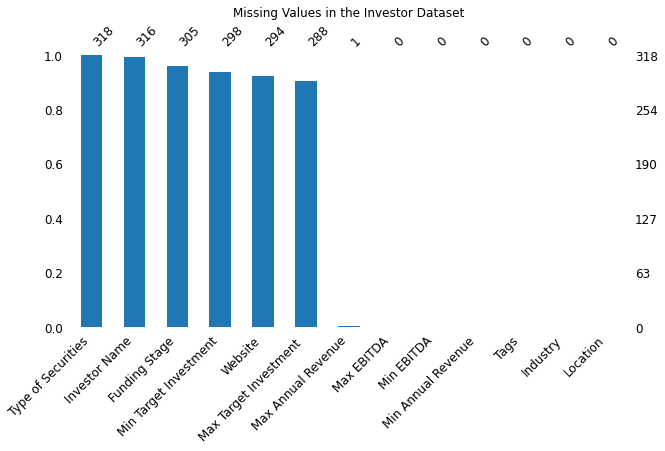

In [8]:
msno.bar(Investors,color="tab:blue", sort="descending", figsize=(10,5), fontsize=12)
plt.title("Missing Values in the Investor Dataset")


In [9]:

# Here there are comparatively less number of null values
Startups.isnull().sum()

Company Name           0
Company Contact        0
Location               0
Description            0
Website                2
Stage                  0
Industry               1
Tags                   1
Target investment      0
Annual Revenue        48
EBITDA                48
Type of Securities     0
dtype: int64

In [10]:
# Data type
Startups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Company Name        48 non-null     object 
 1   Company Contact     48 non-null     object 
 2   Location            48 non-null     object 
 3   Description         48 non-null     object 
 4   Website             46 non-null     object 
 5   Stage               48 non-null     object 
 6   Industry            47 non-null     object 
 7   Tags                47 non-null     object 
 8   Target investment   48 non-null     object 
 9   Annual Revenue      0 non-null      float64
 10  EBITDA              0 non-null      float64
 11  Type of Securities  48 non-null     object 
dtypes: float64(2), object(10)
memory usage: 4.6+ KB


Text(0.5, 1.0, 'Missing values in Startups data')

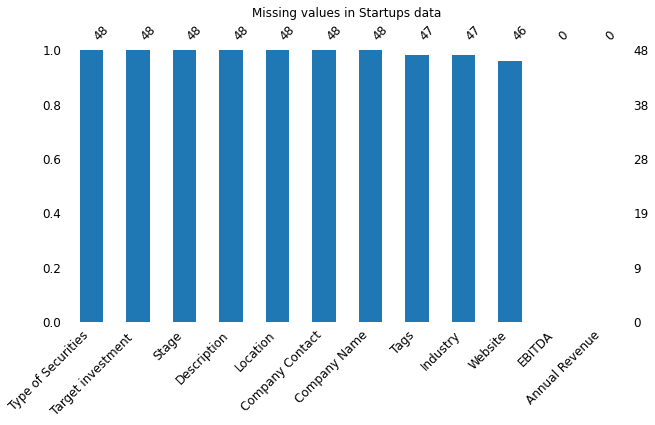

In [11]:
msno.bar(Startups,color="tab:blue", sort="descending", figsize=(10,5), fontsize=12)
plt.title("Missing values in Startups data")

There are null values in both the dataframes i.e startups and investers
 
Let's deal with them first

### 1.2  <a class="anchor" id="1_2"></a> Synthetic Data

In [12]:
# Generating random values for the industry column
# Finding out the number of null values in the industry column, once found, iterate that many times and get a random value from Industry_list
industry_random_list = [random.choice(Industry_list.values)[0] for null_value in range(Investors['Industry'].isnull().sum())]
industry_random_list

['Telecommunications Equipment',
 'Consumer Services',
 'Precious Metals and Mining',
 'Banks',
 'General Industrials',
 'Industrial Materials',
 'Personal Care, Drug and Grocery Stores',
 'Personal Goods',
 'Medical Equipment and Services',
 'Tobacco',
 'Leisure Goods',
 'Pharmaceuticals and Biotechnology',
 'Industrial Support Services',
 'Finance and Credit Services',
 'Consumer Services',
 'Chemicals',
 'Health Care Providers',
 'Industrial Engineering',
 'Open End and Miscellaneous Investment Vehicles',
 'Gas',
 'Banks',
 'Water and Multi-utilities',
 'Medical Equipment and Services',
 'Health Care Providers',
 'Pharmaceuticals and Biotechnology',
 'Medical Equipment and Services',
 'Media',
 'Personal Care, Drug and Grocery Stores',
 'Food Producers',
 'Leisure Goods',
 'Telecommunications Service Providers',
 'Household Goods and Home Construction',
 'Water and Multi-utilities',
 'Technology Hardware and Equipment',
 'Mortgage Real Estate Investment Trusts',
 'Leisure Goods',
 '

In [13]:
# Filling industry null values with the industry random list
Investors.loc[Investors.Industry.isnull(), 'Industry'] = industry_random_list
Investors

,Investor Name,Website,Location,Funding Stage,Industry,Tags,Min Target Investment,Max Target Investment,Min Annual Revenue,Max Annual Revenue,Min EBITDA,Max EBITDA,Type of Securities
0,360 Innovation Lab,www.360-lab.com,NaN,"Pre-Seed, Seed",Telecommunications Equipment,NaN,0,"100,000",NaN,NaN,NaN,NaN,Equity
1,360 Ventures,www.360-lab.com,NaN,"Pre-Seed, Seed",Consumer Services,NaN,"100,000","900,000",NaN,NaN,NaN,NaN,Equity
2,3VC,https://www.three.vc/,NaN,"Pre-Seed, Seed",Precious Metals and Mining,NaN,"100,000","1,000,000",NaN,NaN,NaN,NaN,Equity
3,4Founders Capital,www.4founderscapital.com,NaN,"Pre-Seed, Seed, Series A",Banks,NaN,"50,000","500,000",NaN,NaN,NaN,NaN,Equity
4,7percent Ventures,http://7pc.co/,NaN,Seed,General Industrials,NaN,"200,000","400,000",NaN,NaN,NaN,NaN,Equity
...,...,...,...,...,...,...,...,...,...,...,...,...,...
313,WhatAVenture,https://www.whataventure.com/,NaN,"Pre-Seed, Seed",Non-life Insurance,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Equity
314,William Reeve,www.wreeve.com,NaN,"Seed, Series A",Household Goods and Home Construction,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Equity
315,Yi Luo,NaN,NaN,"Pre-Seed, Seed",Industrial Support Services,NaN,"25,000","100,000",NaN,NaN,NaN,NaN,Equity
316,YouNick Mint,www.younickmint.com,NaN,"Pre-Seed, Seed",Beverages,NaN,0,"200,000",NaN,NaN,NaN,NaN,Equity


In [14]:
# Extracted all the tags from Industry, business, technology to make a single list 
industry_tags = tags_list[['Industry Tags', 'Business Model Tags',
       'Technology Tags']]['Industry Tags'].unique()

business_tags = tags_list[['Industry Tags', 'Business Model Tags',
       'Technology Tags']]['Business Model Tags'].unique()

technology_tags = tags_list[['Industry Tags', 'Business Model Tags',
       'Technology Tags']]['Technology Tags'].unique()

complete_tags = np.concatenate([industry_tags, business_tags, technology_tags])

In [15]:
# Creating combination of 2 tags, 3 tags, 4 tags, 5 tags, etc
tags_2 = list(combinations(complete_tags, 2))
tags_3 = list(combinations(complete_tags, 3))
tags_4 = list(combinations(complete_tags, 4))
tags_5 = list(combinations(complete_tags, 5))
tags_6 = list(combinations(complete_tags, 6))

In [16]:
# Taking random combinations of tags from all these list 62 for tags_2, tags_3, tags_4, tags_5
# 70 for tags_6
# This is taken to in order to get the number to 318 i.e total rows
# 62*4 + 70= 318

In [17]:
tags2 = [random.choice(tags_2) for tag in range(62)]
tags3 = [random.choice(tags_3) for tag in range(62)]
tags4 = [random.choice(tags_4) for tag in range(62)]
tags5 = [random.choice(tags_5) for tag in range(62)]
tags6 = [random.choice(tags_6) for tag in range(70)]

final_tags = tags2 + tags3 + tags4 + tags5 + tags6
final_tags

[('C2B', 'Deep tech'),
 ('Food (Foodtech)', 'Marketplace'),
 (nan, 'Artificial intelligence (AI)'),
 ('Robotics', 'Manufacturing'),
 ('Insurtech', 'Event Tech'),
 ('Hosting', 'Mobile app'),
 ('Media', 'Autonomous & sensor tech'),
 ('Telecom', 'E-commerce'),
 ('Martech', 'Robotics'),
 ('Insurtech', 'Jobs Recruitment'),
 ('Health', 'Mobile app'),
 ('Media', 'HaaS'),
 ('Fashion', 'Mobile app'),
 ('Medtech', 'Autonomous & sensor tech'),
 ('Home Living', 'Deep learning'),
 ('Hosting', 'Iot internetofthings'),
 ('Media', 'Telecom'),
 ('E-commerce', 'Artificial intelligence (AI)'),
 ('B2C', 'HaaS'),
 ('HaaS', 'Recognition technology'),
 ('Nanotech', 'Quantum technologies'),
 ('Wellness Beauty', 'Virtual reality'),
 ('Event Tech', 'Autonomous & sensor tech'),
 ('Energy', 'Hardware'),
 ('Mobile app', nan),
 ('B2C', 'Deep tech'),
 ('Manufacturing', 'Virtual reality'),
 ('Deep tech', 'Autonomous & sensor tech'),
 ('Transportation', '3d technology'),
 ('Jobs Recruitment', 'Event Tech'),
 ('Music',

In [18]:
len(final_tags)

318

In [19]:
# Filling null values in tags with final tags

Investors.loc[Investors.Tags.isnull(), 'Tags'] = final_tags
Investors

,Investor Name,Website,Location,Funding Stage,Industry,Tags,Min Target Investment,Max Target Investment,Min Annual Revenue,Max Annual Revenue,Min EBITDA,Max EBITDA,Type of Securities
0,360 Innovation Lab,www.360-lab.com,NaN,"Pre-Seed, Seed",Telecommunications Equipment,"(C2B, Deep tech)",0,"100,000",NaN,NaN,NaN,NaN,Equity
1,360 Ventures,www.360-lab.com,NaN,"Pre-Seed, Seed",Consumer Services,"(Food (Foodtech), Marketplace)","100,000","900,000",NaN,NaN,NaN,NaN,Equity
2,3VC,https://www.three.vc/,NaN,"Pre-Seed, Seed",Precious Metals and Mining,"(nan, Artificial intelligence (AI))","100,000","1,000,000",NaN,NaN,NaN,NaN,Equity
3,4Founders Capital,www.4founderscapital.com,NaN,"Pre-Seed, Seed, Series A",Banks,"(Robotics, Manufacturing)","50,000","500,000",NaN,NaN,NaN,NaN,Equity
4,7percent Ventures,http://7pc.co/,NaN,Seed,General Industrials,"(Insurtech, Event Tech)","200,000","400,000",NaN,NaN,NaN,NaN,Equity
...,...,...,...,...,...,...,...,...,...,...,...,...,...
313,WhatAVenture,https://www.whataventure.com/,NaN,"Pre-Seed, Seed",Non-life Insurance,"(Health, Gaming, Real Estate (PropTech), E-com...",NaN,NaN,NaN,NaN,NaN,NaN,Equity
314,William Reeve,www.wreeve.com,NaN,"Seed, Series A",Household Goods and Home Construction,"(Insurtech, C2C, Artificial intelligence (AI),...",NaN,NaN,NaN,NaN,NaN,NaN,Equity
315,Yi Luo,NaN,NaN,"Pre-Seed, Seed",Industrial Support Services,"(Dating, Semiconductors, SaaS, C2C, HaaS, Virt...","25,000","100,000",NaN,NaN,NaN,NaN,Equity
316,YouNick Mint,www.younickmint.com,NaN,"Pre-Seed, Seed",Beverages,"(Medtech, Home Living, Robotics, SaaS, Deep te...",0,"200,000",NaN,NaN,NaN,NaN,Equity


In [20]:
# Genearting random numbers for the range you can see below
max_revenue = [random.randrange(1000000, 9000000, 1000) for i in range(317)]
min_revenue = [random.randrange(100000, 900000, 1000) for i in range(318)]

In [21]:
# Filling min and max annual revenue, with random numbers that we generated
Investors.loc[Investors['Min Annual Revenue'].isnull(), 'Min Annual Revenue'] = min_revenue
Investors.loc[Investors['Max Annual Revenue'].isnull(), 'Max Annual Revenue'] = max_revenue

In [22]:
# Genearting random numbers for the range you can see below
max_ebitda = [random.randrange(1000000, 9000000, 1000) for i in range(318)]
min_ebitda = [random.randrange(100000, 900000, 1000) for i in range(318)]

In [23]:
# Filling min and max EBITDA, with random numbers that we generated
Investors.loc[Investors['Min EBITDA'].isnull(), 'Min EBITDA'] = min_ebitda
Investors.loc[Investors['Max EBITDA'].isnull(), 'Max EBITDA'] = max_ebitda

In [24]:
locations = Startups.Location.unique()
locations

array(['Netherlands', 'Ukraine', 'Poland', 'Georgia', 'Portugal',
       'Slovakia', 'United Kingdom'], dtype=object)

In [25]:
# Creating a comprehensive list of all the locations

East_Asia_And_Pacific = ['American Samoa', 'Korea, Rep.', 'Philippines', 'Australia', 'Lao PDR', 'Samoa', 'Brunei Darussalam', 'Macao SAR, China', 'Singapore', 'Cambodia', 'Malaysia', 'Solomon Islands', 'China', 'Marshall Islands', 'Taiwan', 'Fiji', 'Micronesia, Fed. Sts.', 'Thailand', 'French Polynesia', 'Mongolia', 'Timor-Leste', 'Guam', 'Myanmar', 'Papua New Guinea', 'Hong Kong SAR, China', 'Nauru', 'Tonga', 'Indonesia', 'New Caledonia', 'Tuvalu', 'Japan', 'New Zealand', 'Vanuatu', 'Kiribati', 'Northern Mariana Islands', 'Vietnam', "Korea, Dem. People's Rep.", 'Palau']
 
Europe_And_Central_Asia = ['Albania', 'Gibraltar', 'Norway', 'Andorra', 'Greece', 'Poland', 'Armenia', 'Greenland', 'Portugal', 'Austria', 'Hungary', 'Romania', 'Azerbaijan', 'Iceland', 'Russian Federation', 'Belarus', 'Ireland', 'San Marino', 'Belgium', 'Isle of Man', 'Serbia', 'Bosnia and Herzegovina', 'Italy', 'Slovak Republic', 'Bulgaria', 'Kazakhstan', 'Slovenia', 'Channel Islands', 'Kosovo', 'Spain', 'Croatia', 'Kyrgyz Republic', 'Sweden', 'Cyprus', 'Latvia', 'Switzerland', 'Czech Republic', 'Liechtenstein', 'Tajikistan', 'Denmark', 'Lithuania', 'Turkey', 'Estonia', 'Luxembourg', 'Turkmenistan', 'Faroe Islands', 'Moldova', 'Ukraine', 'Finland', 'Monaco', 'United Kingdom', 'France', 'Montenegro', 'Uzbekistan', 'Georgia', 'Netherlands', 'Germany', 'North Macedonia']

Latin_America_And_Caribbean = ['Antigua and Barbuda', 'Curacao', 'Paraguay', 'Argentina', 'Dominica', 'Peru', 'Aruba', 'Dominican Republic', 'Puerto Rico', 'Bahamas, The', 'Ecuador', 'Sint Maarten (Dutch part)', 'Barbados', 'El Salvador', 'St. Kitts and Nevis', 'Belize', 'Grenada', 'St. Lucia', 'Bolivia', 'Guatemala', 'St. Martin (French part)', 'Brazil', 'Guyana', 'St. Vincent and the Grenadines', 'British Virgin Islands', 'Haiti', 'Suriname', 'Cayman Islands', 'Honduras', 'Trinidad and Tobago', 'Chile', 'Jamaica', 'Turks and Caicos Islands', 'Colombia', 'Mexico', 'Uruguay', 'Costa Rica', 'Nicaragua', 'Venezuela, RB', 'Cuba', 'Panama', 'Virgin Islands (U.S.)']

Middle_East_And_North_Africa = ['Algeria', 'Jordan', 'Qatar', 'Bahrain', 'Kuwait', 'Saudi Arabia', 'Djibouti', 'Lebanon', 'Syrian Arab Republic', 'Egypt, Arab Rep.', 'Libya', 'Tunisia', 'Iran, Islamic Rep.', 'Malta', 'United Arab Emirates', 'Iraq', 'Morocco', 'West Bank and Gaza', 'Israel', 'Oman', 'Yemen, Rep.']

North_America = ['Bermuda', 'Canada', 'United States']

South_Asia = ['Afghanistan', 'India', 'Pakistan', 'Bangladesh', 'Maldives', 'Sri Lanka', 'Bhutan', 'Nepal']

Sub_Saharan_Africa = ['Angola', 'Ethiopia', 'Niger', 'Benin', 'Gabon', 'Nigeria', 'Botswana', 'Gambia, The', 'Rwanda', 'Burkina Faso', 'Ghana', 'São Tomé and Principe', 'Burundi', 'Guinea', 'Senegal', 'Cabo Verde', 'Guinea-Bissau', 'Seychelles', 'Cameroon', 'Kenya', 'Sierra Leone', 'Central African Republic', 'Lesotho', 'Somalia', 'Chad', 'Liberia', 'South Africa', 'Comoros', 'Madagascar', 'South Sudan', 'Congo, Dem. Rep.', 'Malawi', 'Sudan', 'Congo, Rep', 'Mali', 'Tanzania', "Côte d'Ivoire", 'Mauritania', 'Togo', 'Equatorial Guinea', 'Mauritius', 'Uganda', 'Eritrea', 'Mozambique', 'Zambia', 'Eswatini', 'Namibia', 'Zimbabwe']

all_locations = East_Asia_And_Pacific + Europe_And_Central_Asia + Latin_America_And_Caribbean + Middle_East_And_North_Africa + North_America + South_Asia

In [26]:
# Fill randomly location 
locations = [random.choice(all_locations) for i in range(318)]
Investors.loc[Investors['Location'].isnull(), 'Location'] = locations
Investors

,Investor Name,Website,Location,Funding Stage,Industry,Tags,Min Target Investment,Max Target Investment,Min Annual Revenue,Max Annual Revenue,Min EBITDA,Max EBITDA,Type of Securities
0,360 Innovation Lab,www.360-lab.com,Vietnam,"Pre-Seed, Seed",Telecommunications Equipment,"(C2B, Deep tech)",0,"100,000",150000.0,5807000,648000.0,3675000.0,Equity
1,360 Ventures,www.360-lab.com,Gibraltar,"Pre-Seed, Seed",Consumer Services,"(Food (Foodtech), Marketplace)","100,000","900,000",485000.0,1832000,682000.0,8916000.0,Equity
2,3VC,https://www.three.vc/,Kyrgyz Republic,"Pre-Seed, Seed",Precious Metals and Mining,"(nan, Artificial intelligence (AI))","100,000","1,000,000",786000.0,6007000,767000.0,1560000.0,Equity
3,4Founders Capital,www.4founderscapital.com,Colombia,"Pre-Seed, Seed, Series A",Banks,"(Robotics, Manufacturing)","50,000","500,000",625000.0,1537000,483000.0,4673000.0,Equity
4,7percent Ventures,http://7pc.co/,Guam,Seed,General Industrials,"(Insurtech, Event Tech)","200,000","400,000",746000.0,6782000,641000.0,3531000.0,Equity
...,...,...,...,...,...,...,...,...,...,...,...,...,...
313,WhatAVenture,https://www.whataventure.com/,Kyrgyz Republic,"Pre-Seed, Seed",Non-life Insurance,"(Health, Gaming, Real Estate (PropTech), E-com...",NaN,NaN,863000.0,5570000,676000.0,8473000.0,Equity
314,William Reeve,www.wreeve.com,Belarus,"Seed, Series A",Household Goods and Home Construction,"(Insurtech, C2C, Artificial intelligence (AI),...",NaN,NaN,108000.0,5637000,420000.0,3952000.0,Equity
315,Yi Luo,NaN,Guam,"Pre-Seed, Seed",Industrial Support Services,"(Dating, Semiconductors, SaaS, C2C, HaaS, Virt...","25,000","100,000",790000.0,1998000,453000.0,7440000.0,Equity
316,YouNick Mint,www.younickmint.com,Suriname,"Pre-Seed, Seed",Beverages,"(Medtech, Home Living, Robotics, SaaS, Deep te...",0,"200,000",635000.0,8082000,713000.0,6978000.0,Equity


Text(0.5, 1.0, 'Number of values for each catgeory in Funding Stage Before Filling Missing Values')

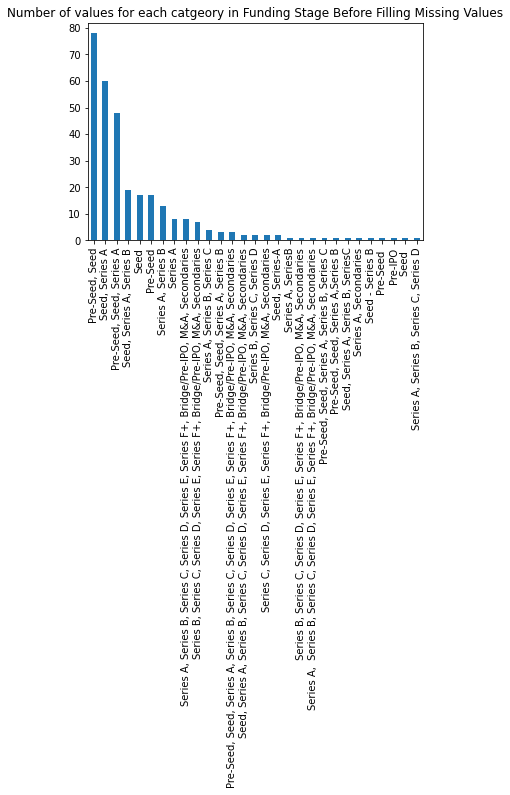

In [27]:
Investors['Funding Stage'].value_counts().plot(kind = 'bar')
plt.title('Number of values for each catgeory in Funding Stage Before Filling Missing Values')

In [28]:
#Filling funding stage, investor name, min and max target investment with mode

Investors['Funding Stage'].fillna(Investors['Funding Stage'].mode()[0], inplace = True)
Investors['Investor Name'].fillna(Investors['Investor Name'].mode()[0], inplace = True)
Investors['Min Target Investment'].fillna( Investors['Min Target Investment'].mode()[0], inplace = True)
Investors['Max Target Investment '].fillna( Investors['Max Target Investment '].mode()[0], inplace = True)

Text(0.5, 1.0, 'Number of values for each catgeory in Funding Stage Before After Missing Values')

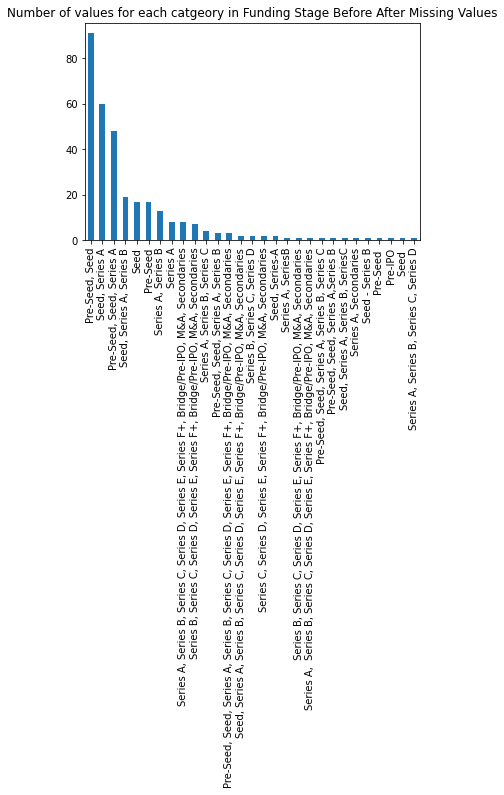

In [29]:
Investors['Funding Stage'].value_counts().plot(kind = 'bar')
plt.title('Number of values for each catgeory in Funding Stage Before After Missing Values')

In [30]:
# Cleaning tags, target investments
Investors['Tags'] = Investors['Tags'].apply(lambda x :  str(x).replace('(', '').replace(')', ''))
Investors['Min Target Investment'] = Investors['Min Target Investment'].apply(lambda x: float(x.replace(',', '')))
Investors['Max Target Investment '] = Investors['Max Target Investment '].apply(lambda x: float(x.replace(',', '')))


Text(0.5, 1.0, 'Count of Type of Securities in Investors')

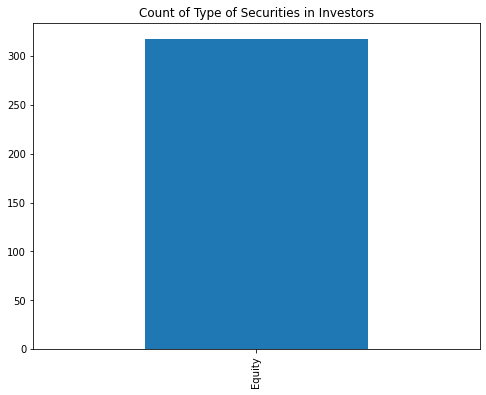

In [31]:
plt.rcParams["figure.figsize"] = (8, 6)

Investors['Type of Securities'].value_counts().plot(kind = 'bar')
plt.title('Count of Type of Securities in Investors')

In [32]:
# Replacing a string, it was the only string in this column
Investors[Investors['Max Annual Revenue']=='1,000,000'] = 1000000

In [33]:
# Changing type of column
Investors['Max Annual Revenue'] = Investors['Max Annual Revenue'].astype(float)

Text(0.5, 1.0, 'Max Target investement distribution')

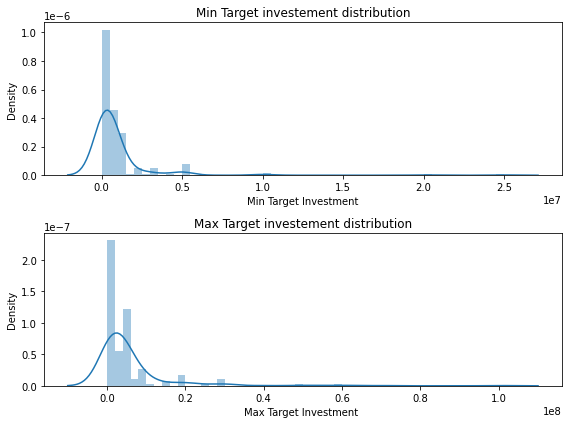

<Figure size 1440x864 with 0 Axes>

In [34]:
fig, axes = plt.subplots(2, 1, tight_layout=True)
plt.figure(figsize = (20,12))

sns.distplot(Investors['Min Target Investment'], ax=axes[0])
axes[0].set_title("Min Target investement distribution")

sns.distplot(Investors['Max Target Investment '], ax=axes[1])
axes[1].set_title("Max Target investement distribution")


Text(0.5, 1.0, 'Max Annual Revenue distribution')

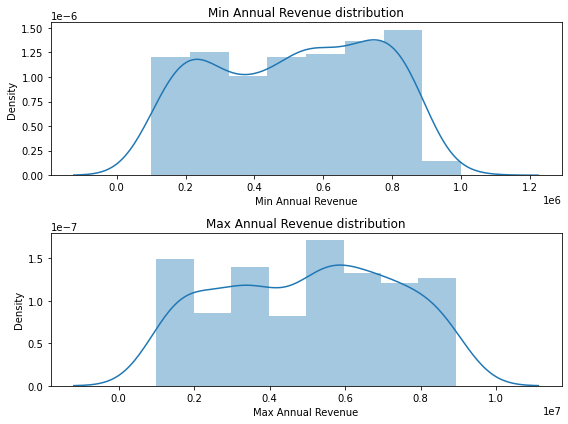

<Figure size 1440x864 with 0 Axes>

In [35]:

fig, axes = plt.subplots(2, 1, tight_layout=True)
plt.figure(figsize = (20,12))

sns.distplot(Investors['Min Annual Revenue'], ax=axes[0])
axes[0].set_title("Min Annual Revenue distribution")

sns.distplot(Investors['Max Annual Revenue'], ax=axes[1])
axes[1].set_title("Max Annual Revenue distribution")


In [36]:
# Fill NaN values
Startups['Industry'].fillna(Startups['Industry'].mode()[0], inplace = True)

In [37]:
Startups.loc[Startups['Company Name'] == 'Market place for volunteer projects in Ukraine']

,Company Name,Company Contact,Location,Description,Website,Stage,Industry,Tags,Target investment,Annual Revenue,EBITDA,Type of Securities
45,Market place for volunteer projects in Ukraine,Mykola Golubei,Ukraine,#NAME?,https://instagram.com/teleport_foundation,Pre-seed,Software and Computer Services,NaN,"100,000",NaN,NaN,Equity


Text(0.5, 1.0, 'Count of industries')

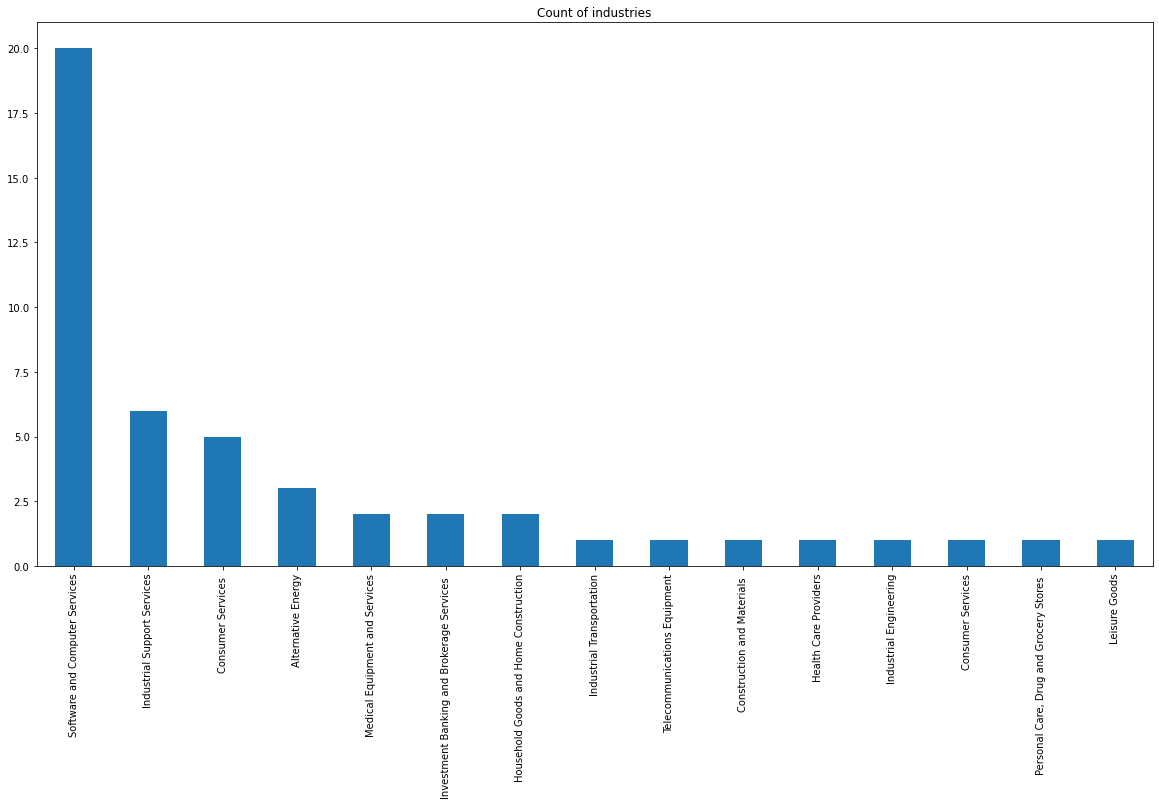

In [38]:
plt.rcParams["figure.figsize"] = (20, 10)

Startups['Industry'].value_counts().plot(kind = 'bar')
plt.title('Count of industries')

In [39]:
# Fill NaN values
Startups['Tags'].fillna(Startups['Tags'].mode()[0], inplace = True)

Text(0.5, 1.0, 'Count of Tags')

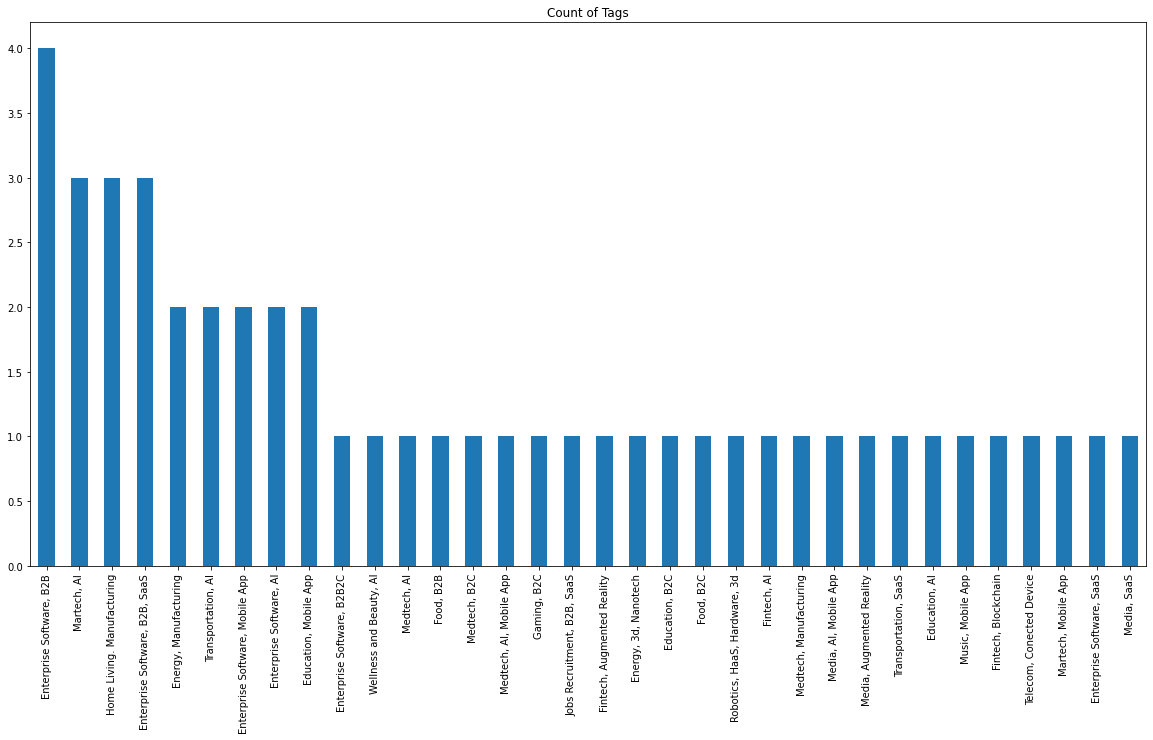

In [40]:
plt.rcParams["figure.figsize"] = (20, 10)

Startups['Tags'].value_counts().plot(kind = 'bar')
plt.title('Count of Tags')

In [41]:
# Change the data type
Investors['Tags'] = Investors['Tags'].astype(str)

In [42]:
# Cleaning tags
Investors['Tags'] = Investors['Tags'].apply(lambda x: x.replace("'", ""))

In [43]:
# Filling missing values in Annual Revenue with 
Startups['Annual Revenue'].fillna( Startups['Annual Revenue'].mode(), inplace = True)


In [44]:
# Cleaning target investment
Startups['Target investment '] = Startups['Target investment '].apply(lambda x: float(x.replace(',', '')))


Text(0.5, 1.0, 'Target investment  distribution')

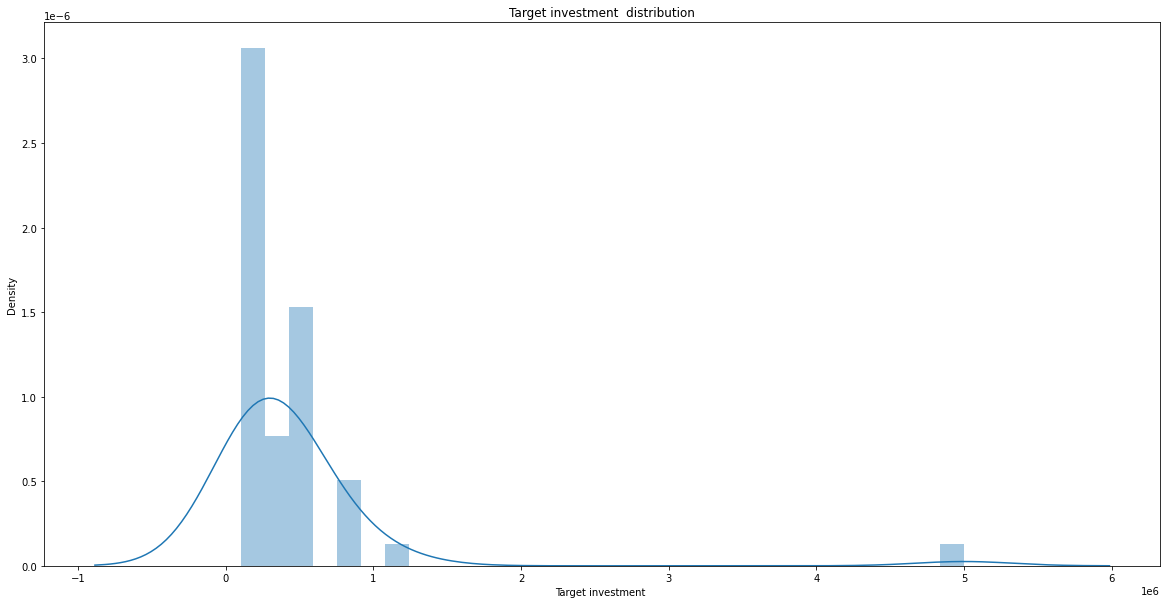

In [45]:

sns.distplot(Startups['Target investment '])
plt.title("Target investment  distribution")


## Chapter 2: <a class="anchor" id="chapter2"></a> Preprocessing

In [46]:
# There is no joining column, so a cross join would be performed

Startups['key'] = 1
Investors['key'] = 1
  
# to obtain the cross join we will merge on the key and drop it.
result = pd.merge(Startups, Investors, on ='key').drop("key", 1)

In [47]:
result['Industry_x'] = result['Industry_x'].astype(str)
result['Industry_y'] = result['Industry_y'].astype(str)
result['Tags_x'] = result['Tags_x'].astype(str)
result['Tags_y'] = result['Tags_y'].astype(str)
result['Location_x'] = result['Location_x'].astype(str)
result['Location_y'] = result['Location_y'].astype(str)
result['Type of Securities_x'] = result['Type of Securities_x'].astype(str)
result['Type of Securities_y'] = result['Type of Securities_y'].astype(str)
result['Stage'] = result['Stage'].astype(str)
result['Funding Stage'] = result['Funding Stage'].astype(str)

In [48]:
# Show the data frame
result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15264 entries, 0 to 15263
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Company Name            15264 non-null  object 
 1   Company Contact         15264 non-null  object 
 2   Location_x              15264 non-null  object 
 3   Description             15264 non-null  object 
 4   Website_x               14628 non-null  object 
 5   Stage                   15264 non-null  object 
 6   Industry_x              15264 non-null  object 
 7   Tags_x                  15264 non-null  object 
 8   Target investment       15264 non-null  float64
 9   Annual Revenue          0 non-null      float64
 10  EBITDA                  0 non-null      float64
 11  Type of Securities_x    15264 non-null  object 
 12  Investor Name           15264 non-null  object 
 13  Website_y               14112 non-null  object 
 14  Location_y              15264 non-null

## Chapter 3: <a class="anchor" id="chapter3"></a> Algorithms


### 3.1  <a class="anchor" id="3_1"></a> Cosine Similarity

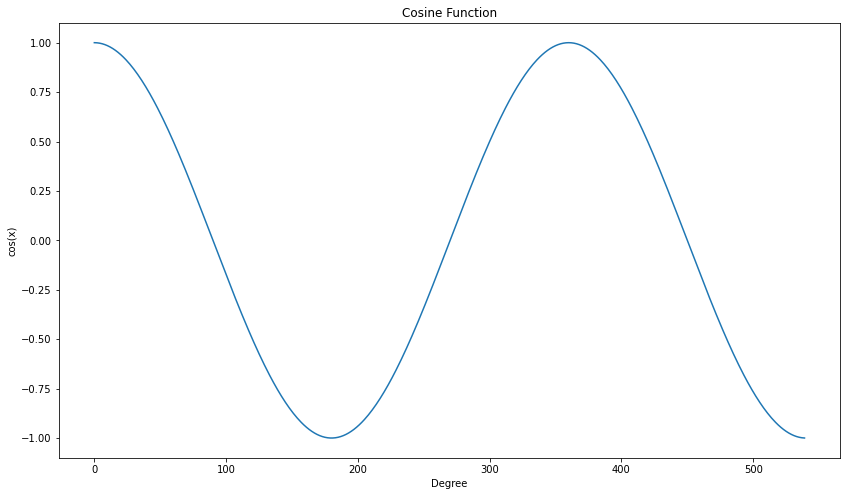

In [50]:
# Plot cosine function's graph
import matplotlib.pyplot as plt
import math

grad = []
cos = []


for i in range(0,540):
	grad.append(i)
	radianes = (i* math.pi)/180
	cos.append(math.cos(radianes))

plt.figure(figsize=(14, 8))	
plt.ylim(-1.1,1.1)
plt.plot(grad,cos)
plt.xlabel('Degree')
plt.ylabel('cos(x)')
plt.title('Cosine Function')
plt.show()

In [51]:
# # Getting similarity scores between columns of investor and startup datasets
# import math
# import re
# from collections import Counter

# WORD = re.compile(r"\w+")


# # def get_cosine(vec1, vec2):
# #     intersection = set(vec1.keys()) & set(vec2.keys())
# #     numerator = sum([vec1[x] * vec2[x] for x in intersection])

# #     sum1 = sum([vec1[x] ** 2 for x in list(vec1.keys())])
# #     sum2 = sum([vec2[x] ** 2 for x in list(vec2.keys())])
# #     denominator = math.sqrt(sum1) * math.sqrt(sum2)

# #     if not denominator:
# #         return 0.0
# #     else:
# #         return float(numerator) / denominator

# def get_cosine_similarity(term1, term2):
#     words1 = WORD.findall(term1)
#     vec1= Counter(words1)
#     words2 = WORD.findall(term2)
#     vec2 = Counter(words2)
    
#     intersection = set(vec1.keys()) & set(vec2.keys())
#     numerator = sum([vec1[x] * vec2[x] for x in intersection])

#     sum1 = sum([vec1[x] ** 2 for x in list(vec1.keys())])
#     sum2 = sum([vec2[x] ** 2 for x in list(vec2.keys())])
#     denominator = math.sqrt(sum1) * math.sqrt(sum2)

#     if not denominator:
#         return 0.0
#     else:
#         return float(numerator) / denominator

# result['Industry_Similarity' ] = result.apply(lambda x: get_cosine_similarity(x['Industry_x'], x['Industry_y']), axis = 1)
# result['Tags_Similarity' ] = result.apply(lambda x: get_cosine_similarity(x['Tags_x'], x['Tags_y']), axis = 1)
# result['Location_Similarity' ] = result.apply(lambda x: get_cosine_similarity(x['Location_x'], x['Location_y']), axis = 1)
# result['Funding_Stage_Similarity' ] = result.apply(lambda x: get_cosine_similarity(x['Stage'], x['Funding Stage']), axis = 1)
# result['Investment_Similarity'] = result.apply(lambda x: 1 if x['Target investment '] <= x['Max Target Investment '] and x['Target investment '] >= x['Min Target Investment'] else 0, axis = 1)
# result['Annual_Revenue_Similarity'] = result.apply(lambda x: 1 if x['Annual Revenue'] <= x['Max Annual Revenue'] and x['Annual Revenue'] >= x['Min Annual Revenue'] else 0, axis = 1)
# result['EBITDA_Similarity'] = result.apply(lambda x: 1 if x['EBITDA'] <= x['Max EBITDA'] and x['Annual Revenue'] >= x['Min EBITDA'] else 0, axis = 1)



In [52]:
# # Weight assignment
# result['Industry_Similarity_Score'] = result.apply(lambda x: 0 if x['Industry_Similarity']<0.7 else 20, axis = 1)
# result['Tags_Similarity_Score'] = result.apply(lambda x: 0 if x['Tags_Similarity']<0.10 else(5 if x['Tags_Similarity']>=.10 and  x['Tags_Similarity']<=.25 else (10 if x['Tags_Similarity']>.25 and  x['Tags_Similarity']<=.50 else (15 if x['Tags_Similarity']>.50 and  x['Tags_Similarity']<=0.75 else 20))), axis = 1 )
# result['Location_Similarity_Score'] = result.apply(lambda x: 0 if x['Location_Similarity']<0.7 else 20, axis = 1)
# result['Funding_Stage_Similarity_Score'] = result.apply(lambda x: 0 if x['Funding_Stage_Similarity']<0.7 else 20, axis = 1)
# result['Annual_Revenue_Similarity_Score'] = result.apply(lambda x: 20 if x['Annual_Revenue_Similarity']==1 else 0, axis =1  )
# result['Investment_Similarity_Score'] = result.apply(lambda x: 20 if x['Investment_Similarity']==1 else 0, axis = 1 )
# result['EBITDA_Similarity_Score'] = result.apply(lambda x: 20 if x['EBITDA_Similarity']==1 else 0, axis = 1 )

### 3.2  <a class="anchor" id="3_2"></a> Damerau-Lavenstein

In [53]:
# # Code retrieved from https://programtalk.com/python-examples/jellyfish.levenshtein_distance/
# def get_levenshtein_distance(str1, str2):
#     """Basic edit distance between two strings, ignoring
#     non-alphanumeric characters and case. Comparisons are based on a
#     transliteration/lowering to ASCII characters. Normalized by string
#     length.
#     """
#     assert isinstance(str1, six.text_type)
#     assert isinstance(str2, six.text_type)
#     str1 = as_string(unidecode(str1))
#     str2 = as_string(unidecode(str2))
#     str1 = re.sub(r'[^a-z0-9]', '', str1.lower())
#     str2 = re.sub(r'[^a-z0-9]', '', str2.lower())
#     if not str1 and not str2:
#         return 0.0
#     return 1 - (levenshtein_distance(str1, str2) / float(max(len(str1), len(str2))))

# result['Industry_Similarity' ] = result.apply(lambda x: get_levenshtein_distance(x['Industry_x'], x['Industry_y']), axis = 1)
# result['Tags_Similarity' ] = result.apply(lambda x: get_levenshtein_distance(x['Tags_x'], x['Tags_y']), axis = 1)
# result['Location_Similarity' ] = result.apply(lambda x: get_levenshtein_distance(x['Location_x'], x['Location_y']), axis = 1)
# result['Funding_Stage_Similarity' ] = result.apply(lambda x: get_levenshtein_distance(x['Stage'], x['Funding Stage']), axis = 1)
# result['Investment_Similarity'] = result.apply(lambda x: 1 if x['Target investment '] <= x['Max Target Investment '] and x['Target investment '] >= x['Min Target Investment'] else 0, axis = 1)
# result['Annual_Revenue_Similarity'] = result.apply(lambda x: 1 if x['Annual Revenue'] <= x['Max Annual Revenue'] and x['Annual Revenue'] >= x['Min Annual Revenue'] else 0, axis = 1)
# result['EBITDA_Similarity'] = result.apply(lambda x: 1 if x['EBITDA'] <= x['Max EBITDA'] and x['Annual Revenue'] >= x['Min EBITDA'] else 0, axis = 1)

In [54]:
# #def get_levenshtein_distance(term1, term2):
#     #return levenshtein.distance(term1, term2)

# result['Industry_Similarity' ] = result.apply(lambda x: get_levenshtein_distance(x['Industry_x'], x['Industry_y']), axis = 1)
# result['Tags_Similarity' ] = result.apply(lambda x: get_levenshtein_distance(x['Tags_x'], x['Tags_y']), axis = 1)
# result['Location_Similarity' ] = result.apply(lambda x: get_levenshtein_distance(x['Location_x'], x['Location_y']), axis = 1)
# result['Funding_Stage_Similarity' ] = result.apply(lambda x: get_levenshtein_distance(x['Stage'], x['Funding Stage']), axis = 1)
# result['Investment_Similarity'] = result.apply(lambda x: 1 if x['Target investment '] <= x['Max Target Investment '] and x['Target investment '] >= x['Min Target Investment'] else 0, axis = 1)
# result['Annual_Revenue_Similarity'] = result.apply(lambda x: 1 if x['Annual Revenue'] <= x['Max Annual Revenue'] and x['Annual Revenue'] >= x['Min Annual Revenue'] else 0, axis = 1)
# result['EBITDA_Similarity'] = result.apply(lambda x: 1 if x['EBITDA'] <= x['Max EBITDA'] and x['Annual Revenue'] >= x['Min EBITDA'] else 0, axis = 1)

In [55]:
# # Weight assignment
# result['Industry_Similarity_Score'] = result.apply(lambda x: 0 if x['Industry_Similarity']<0.7 else 20, axis = 1)
# result['Tags_Similarity_Score'] = result.apply(lambda x: 0 if x['Tags_Similarity']<0.10 else(5 if x['Tags_Similarity']>=.10 and  x['Tags_Similarity']<=.25 else (10 if x['Tags_Similarity']>.25 and  x['Tags_Similarity']<=.50 else (15 if x['Tags_Similarity']>.50 and  x['Tags_Similarity']<=0.75 else 20))), axis = 1 )
# result['Location_Similarity_Score'] = result.apply(lambda x: 0 if x['Location_Similarity']<0.7 else 20, axis = 1)
# result['Funding_Stage_Similarity_Score'] = result.apply(lambda x: 0 if x['Funding_Stage_Similarity']<0.7 else 20, axis = 1)
# result['Annual_Revenue_Similarity_Score'] = result.apply(lambda x: 20 if x['Annual_Revenue_Similarity']==1 else 0, axis =1  )
# result['Investment_Similarity_Score'] = result.apply(lambda x: 20 if x['Investment_Similarity']==1 else 0, axis = 1 )
# result['EBITDA_Similarity_Score'] = result.apply(lambda x: 20 if x['EBITDA_Similarity']==1 else 0, axis = 1 )

### 3.3  <a class="anchor" id="3_2"></a> SequenceMatcher

In [56]:
# # Getting similarity between columns of investor data and startup
# def get_sequence_matcher_similarity(term1, term2):

#     sequence = difflib.SequenceMatcher( a = term1.lower(), b = term2.lower())
#     return sequence.ratio()

# result['Industry_Similarity' ] = result.apply(lambda x: get_sequence_matcher_similarity(x['Industry_x'], x['Industry_y']), axis = 1)
# result['Tags_Similarity' ] = result.apply(lambda x: get_sequence_matcher_similarity(x['Tags_x'], x['Tags_y']), axis = 1)
# result['Location_Similarity' ] = result.apply(lambda x: get_sequence_matcher_similarity(x['Location_x'], x['Location_y']), axis = 1)
# result['Funding_Stage_Similarity' ] = result.apply(lambda x: get_sequence_matcher_similarity(x['Stage'], x['Funding Stage']), axis = 1)
# result['Investment_Similarity'] = result.apply(lambda x: 1 if x['Target investment '] <= x['Max Target Investment '] and x['Target investment '] >= x['Min Target Investment'] else 0, axis = 1)
# result['Annual_Revenue_Similarity'] = result.apply(lambda x: 1 if x['Annual Revenue'] <= x['Max Annual Revenue'] and x['Annual Revenue'] >= x['Min Annual Revenue'] else 0, axis = 1)
# result['EBITDA_Similarity'] = result.apply(lambda x: 1 if x['EBITDA'] <= x['Max EBITDA'] and x['Annual Revenue'] >= x['Min EBITDA'] else 0, axis = 1)
# # how the sequence matcher distance called
# # result.apply(lambda x: get_sequence_matcher_similarity(x['Industry_x'], x['Industry_y']), axis = 1)

In [57]:
# # Weight assignment
# result['Industry_Similarity_Score'] = result.apply(lambda x: 0 if x['Industry_Similarity']<0.7 else 20, axis = 1)
# result['Tags_Similarity_Score'] = result.apply(lambda x: 0 if x['Tags_Similarity']<0.10 else(5 if x['Tags_Similarity']>=.10 and  x['Tags_Similarity']<=.25 else (10 if x['Tags_Similarity']>.25 and  x['Tags_Similarity']<=.50 else (15 if x['Tags_Similarity']>.50 and  x['Tags_Similarity']<=0.75 else 20))), axis = 1 )
# result['Location_Similarity_Score'] = result.apply(lambda x: 0 if x['Location_Similarity']<0.7 else 20, axis = 1)
# result['Funding_Stage_Similarity_Score'] = result.apply(lambda x: 0 if x['Funding_Stage_Similarity']<0.7 else 20, axis = 1)
# result['Annual_Revenue_Similarity_Score'] = result.apply(lambda x: 20 if x['Annual_Revenue_Similarity']==1 else 0, axis =1  )
# result['Investment_Similarity_Score'] = result.apply(lambda x: 20 if x['Investment_Similarity']==1 else 0, axis = 1 )
# result['EBITDA_Similarity_Score'] = result.apply(lambda x: 20 if x['EBITDA_Similarity']==1 else 0, axis = 1 )

### 3.4  <a class="anchor" id="3_4"></a> Tokenisation

In [58]:
# Tokenizing the strings, and converting to set. Then I'll compare if all the tokens found in industry x are in industry y also
# If all tokens match then assign it 1 else 0
# nltk.download('punkt')
result['Industry_Similarity'] = result.apply(lambda x: 1 if set(nltk.word_tokenize(x['Industry_x'].lower())) == set(nltk.word_tokenize(x['Industry_y'].lower())) else 0, axis=1)
result['Location_Similarity'] = result.apply(lambda x: 1 if set(x['Location_x'].lower().split(',')).intersection(set(x['Location_y'].lower().split(','))) else 0, axis = 1)
result['Tags_Similarity'] = result.apply( lambda x: len(set(x['Tags_x'].lower().split(',')).intersection(set(x['Tags_y'].lower().split(',')))), axis = 1)
result['Funding_Stage_Similarity'] = result.apply(lambda x: 1 if set(x['Stage'].lower().split(',')).intersection(set(x['Funding Stage'].lower().split(','))) else 0, axis = 1)
result['Investment_Similarity'] = result.apply(lambda x: 1 if x['Target investment '] <= x['Max Target Investment '] and x['Target investment '] >= x['Min Target Investment'] else 0, axis = 1)
result['Annual_Revenue_Similarity'] = result.apply(lambda x: 1 if x['Annual Revenue'] <= x['Max Annual Revenue'] and x['Annual Revenue'] >= x['Min Annual Revenue'] else 0, axis = 1)
result['EBITDA_Similarity'] = result.apply(lambda x: 1 if x['EBITDA'] <= x['Max EBITDA'] and x['Annual Revenue'] >= x['Min EBITDA'] else 0, axis = 1)

In [59]:
# Assigning weight to the features
result['Industry_Similarity_Score'] = result.apply(lambda x: 20 if x['Industry_Similarity']==1 else 0, axis = 1 )
result['Tags_Similarity_Score'] = result['Tags_Similarity'].apply(lambda x: 0 if x==0 else(5 if x==1 else(10 if x==2 else (15 if x==3 else(20 if x==4 else 20)))))
result['Location_Similarity_Score'] = result.apply(lambda x: 20 if x['Location_Similarity']==1 else 0, axis = 1 )
result['Funding_Stage_Similarity_Score'] = result.apply(lambda x: 20 if x['Funding_Stage_Similarity']==1 else 0, axis = 1 )
result['Annual_Revenue_Similarity_Score'] = result.apply(lambda x: 20 if x['Annual_Revenue_Similarity']==1 else 0, axis =1  )
result['Investment_Similarity_Score'] = result.apply(lambda x: 20 if x['Investment_Similarity']==1 else 0, axis = 1 )
result['EBITDA_Similarity_Score'] = result.apply(lambda x: 20 if x['EBITDA_Similarity']==1 else 0, axis = 1 )
#result.drop('Tags_Similarity', axis =1, inplace = True)

### 3.5  <a class="anchor" id="3_5"></a> Total Percentage Match Variable

In [60]:
# A final score is a sum of all these scores
result['Final_Score'] = result['Industry_Similarity_Score'] + result['Tags_Similarity_Score'] + result['Location_Similarity_Score'] + result['Funding_Stage_Similarity_Score'] + result['Annual_Revenue_Similarity_Score'] + result['Investment_Similarity_Score'] + result['EBITDA_Similarity_Score']


## Chapter 4: <a class="anchor" id="chapter4"></a> Matched Combinations and Human Analysis

In [85]:
# Access the investor-startup matches
result.iloc[2200]

Company Name                                                        OneStake Finance
Company Contact                                                        Oleksii Koval
Location_x                                                                   Ukraine
Description                                  The highest APR directly to your wallet
Website_x                                                   https://onestake.finance
Stage                                                                       Pre-seed
Industry_x                                Investment Banking and Brokerage Services 
Tags_x                                                           Fintech, Blockchain
Target investment                                                           540000.0
Annual Revenue                                                                   NaN
EBITDA                                                                           NaN
Type of Securities_x                                             

In [62]:
# Access matches where n number of tags matched
result.loc[result['Tags_Similarity_Score'] == 10]

,Company Name,Company Contact,Location_x,Description,Website_x,Stage,Industry_x,Tags_x,Target investment,Annual Revenue,...,Annual_Revenue_Similarity,EBITDA_Similarity,Industry_Similarity_Score,Tags_Similarity_Score,Location_Similarity_Score,Funding_Stage_Similarity_Score,Annual_Revenue_Similarity_Score,Investment_Similarity_Score,EBITDA_Similarity_Score,Final_Score
1198,SplineCloud,Vadym Pasko,Ukraine,SplineCloud is a knowledge management platform...,https://splinecloud.com,Pre-seed,Software and Computer Services,"Enterprise Software, SaaS",850000.0,NaN,...,0,0,0,10,0,0,0,0,0,10
1204,SplineCloud,Vadym Pasko,Ukraine,SplineCloud is a knowledge management platform...,https://splinecloud.com,Pre-seed,Software and Computer Services,"Enterprise Software, SaaS",850000.0,NaN,...,0,0,0,10,0,0,0,20,0,30
1567,Nection.io,Alex Vasylenko,Ukraine,Safest personal CRM for individual business re...,https://nection.io,Seed,Software and Computer Services,"Martech, Mobile App",800000.0,NaN,...,0,0,0,10,0,0,0,0,0,10
2102,OneStake Finance,Oleksii Koval,Ukraine,The highest APR directly to your wallet,https://onestake.finance,Pre-seed,Investment Banking and Brokerage Services,"Fintech, Blockchain",540000.0,NaN,...,0,0,0,10,0,0,0,0,0,10
2156,OneStake Finance,Oleksii Koval,Ukraine,The highest APR directly to your wallet,https://onestake.finance,Pre-seed,Investment Banking and Brokerage Services,"Fintech, Blockchain",540000.0,NaN,...,0,0,0,10,0,20,0,0,0,30
3948,InputSoft,Anastasiia Smyk,Ukraine,InputSoft develops a SaaS web platform for air...,https://www.inputsoft.net/,Pre-seed,Software and Computer Services,"Transportation, SaaS",500000.0,NaN,...,0,0,0,10,0,0,0,20,0,30
4016,InputSoft,Anastasiia Smyk,Ukraine,InputSoft develops a SaaS web platform for air...,https://www.inputsoft.net/,Pre-seed,Software and Computer Services,"Transportation, SaaS",500000.0,NaN,...,0,0,0,10,0,0,0,0,0,10
4085,InputSoft,Anastasiia Smyk,Ukraine,InputSoft develops a SaaS web platform for air...,https://www.inputsoft.net/,Pre-seed,Software and Computer Services,"Transportation, SaaS",500000.0,NaN,...,0,0,0,10,0,0,0,20,0,30
4658,NLSQL,Denis Chernenko,Ukraine,NLSQL is B2B SaaS to empower employees with in...,https://nlsql.com,Seed,Software and Computer Services,"Enterprise Software, B2B, SaaS",500000.0,NaN,...,0,0,0,10,0,20,0,0,0,30
4696,NLSQL,Denis Chernenko,Ukraine,NLSQL is B2B SaaS to empower employees with in...,https://nlsql.com,Seed,Software and Computer Services,"Enterprise Software, B2B, SaaS",500000.0,NaN,...,0,0,0,10,0,20,0,0,0,30


In [63]:
result.loc[(result['Stage'] == 'Seed') & (result['Funding Stage'] == 'Pre-Seed')]

,Company Name,Company Contact,Location_x,Description,Website_x,Stage,Industry_x,Tags_x,Target investment,Annual Revenue,...,Annual_Revenue_Similarity,EBITDA_Similarity,Industry_Similarity_Score,Tags_Similarity_Score,Location_Similarity_Score,Funding_Stage_Similarity_Score,Annual_Revenue_Similarity_Score,Investment_Similarity_Score,EBITDA_Similarity_Score,Final_Score
7,Cardiomo,Ksenia Belkina,Netherlands,Cardiomo is an innovative medtech company that...,https://www.cardiomo.com,Seed,Medical Equipment and Services,"Medtech, AI",5000000.0,NaN,...,0,0,0,0,0,0,0,20,0,20
12,Cardiomo,Ksenia Belkina,Netherlands,Cardiomo is an innovative medtech company that...,https://www.cardiomo.com,Seed,Medical Equipment and Services,"Medtech, AI",5000000.0,NaN,...,0,0,0,0,0,0,0,0,0,0
13,Cardiomo,Ksenia Belkina,Netherlands,Cardiomo is an innovative medtech company that...,https://www.cardiomo.com,Seed,Medical Equipment and Services,"Medtech, AI",5000000.0,NaN,...,0,0,0,5,0,0,0,0,0,5
14,Cardiomo,Ksenia Belkina,Netherlands,Cardiomo is an innovative medtech company that...,https://www.cardiomo.com,Seed,Medical Equipment and Services,"Medtech, AI",5000000.0,NaN,...,0,0,0,0,0,0,0,0,0,0
18,Cardiomo,Ksenia Belkina,Netherlands,Cardiomo is an innovative medtech company that...,https://www.cardiomo.com,Seed,Medical Equipment and Services,"Medtech, AI",5000000.0,NaN,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15042,XLSheet Bot,Oleksandr Tymchenko,Ukraine,SaaS platform to create Telegram chatbots with...,https://xlsheetbot.com/,Seed,Software and Computer Services,"Media, SaaS",100000.0,NaN,...,0,0,0,0,0,0,0,20,0,20
15048,XLSheet Bot,Oleksandr Tymchenko,Ukraine,SaaS platform to create Telegram chatbots with...,https://xlsheetbot.com/,Seed,Software and Computer Services,"Media, SaaS",100000.0,NaN,...,0,0,0,0,0,0,0,20,0,20
15071,XLSheet Bot,Oleksandr Tymchenko,Ukraine,SaaS platform to create Telegram chatbots with...,https://xlsheetbot.com/,Seed,Software and Computer Services,"Media, SaaS",100000.0,NaN,...,0,0,20,0,0,0,0,20,0,40
15089,XLSheet Bot,Oleksandr Tymchenko,Ukraine,SaaS platform to create Telegram chatbots with...,https://xlsheetbot.com/,Seed,Software and Computer Services,"Media, SaaS",100000.0,NaN,...,0,0,0,0,0,0,0,0,0,0


In [64]:
# Access matches where funding stage variable has more than one input
result.loc[(result['Funding Stage'] == 'Pre-Seed, Seed, Series A') & (result['Funding_Stage_Similarity_Score'] == 20)]

,Company Name,Company Contact,Location_x,Description,Website_x,Stage,Industry_x,Tags_x,Target investment,Annual Revenue,...,Annual_Revenue_Similarity,EBITDA_Similarity,Industry_Similarity_Score,Tags_Similarity_Score,Location_Similarity_Score,Funding_Stage_Similarity_Score,Annual_Revenue_Similarity_Score,Investment_Similarity_Score,EBITDA_Similarity_Score,Final_Score
321,WePro,Pavel Vlodov,Ukraine,Wepro Bank is the only smart bank with built-i...,https://thewepro.com/,Pre-seed,Investment Banking and Brokerage Services,"Fintech, AI",1200000.0,NaN,...,0,0,0,0,0,20,0,0,0,20
333,WePro,Pavel Vlodov,Ukraine,Wepro Bank is the only smart bank with built-i...,https://thewepro.com/,Pre-seed,Investment Banking and Brokerage Services,"Fintech, AI",1200000.0,NaN,...,0,0,0,0,0,20,0,20,0,40
351,WePro,Pavel Vlodov,Ukraine,Wepro Bank is the only smart bank with built-i...,https://thewepro.com/,Pre-seed,Investment Banking and Brokerage Services,"Fintech, AI",1200000.0,NaN,...,0,0,0,0,0,20,0,0,0,20
360,WePro,Pavel Vlodov,Ukraine,Wepro Bank is the only smart bank with built-i...,https://thewepro.com/,Pre-seed,Investment Banking and Brokerage Services,"Fintech, AI",1200000.0,NaN,...,0,0,0,0,0,20,0,20,0,40
369,WePro,Pavel Vlodov,Ukraine,Wepro Bank is the only smart bank with built-i...,https://thewepro.com/,Pre-seed,Investment Banking and Brokerage Services,"Fintech, AI",1200000.0,NaN,...,0,0,0,0,0,20,0,20,0,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14911,3D Nanocom,Viktor Hamalii,Ukraine,Synthesis of nanocomposites in 3D aeroform wit...,https://3dnano.com.ua/uk/,Pre-seed,Alternative Energy,"Energy, 3d, Nanotech",100000.0,NaN,...,0,0,0,0,0,20,0,0,0,20
14912,3D Nanocom,Viktor Hamalii,Ukraine,Synthesis of nanocomposites in 3D aeroform wit...,https://3dnano.com.ua/uk/,Pre-seed,Alternative Energy,"Energy, 3d, Nanotech",100000.0,NaN,...,0,0,0,0,0,20,0,20,0,40
14916,3D Nanocom,Viktor Hamalii,Ukraine,Synthesis of nanocomposites in 3D aeroform wit...,https://3dnano.com.ua/uk/,Pre-seed,Alternative Energy,"Energy, 3d, Nanotech",100000.0,NaN,...,0,0,0,0,0,20,0,0,0,20
14923,3D Nanocom,Viktor Hamalii,Ukraine,Synthesis of nanocomposites in 3D aeroform wit...,https://3dnano.com.ua/uk/,Pre-seed,Alternative Energy,"Energy, 3d, Nanotech",100000.0,NaN,...,0,0,0,0,0,20,0,20,0,40


## Chapter 5: <a class="anchor" id="chapter5"></a> Final Output 

### 5.1  <a class="anchor" id="5_1"></a> Equity Matches

In [65]:
# Matches between 81% and 100% (Equity)
result[(result['Type of Securities_x']== 'Equity') & (result['Type of Securities_y']== 'Equity') & ( result['Final_Score']> 80) & (result['Final_Score']<= 140)]

,Company Name,Company Contact,Location_x,Description,Website_x,Stage,Industry_x,Tags_x,Target investment,Annual Revenue,...,Annual_Revenue_Similarity,EBITDA_Similarity,Industry_Similarity_Score,Tags_Similarity_Score,Location_Similarity_Score,Funding_Stage_Similarity_Score,Annual_Revenue_Similarity_Score,Investment_Similarity_Score,EBITDA_Similarity_Score,Final_Score


In [66]:
# Matches between 61% and 80% (Equity)
result[(result['Type of Securities_x']== 'Equity') & (result['Type of Securities_y']== 'Equity') & ( result['Final_Score']> 60) & (result['Final_Score']<= 80)]

,Company Name,Company Contact,Location_x,Description,Website_x,Stage,Industry_x,Tags_x,Target investment,Annual Revenue,...,Annual_Revenue_Similarity,EBITDA_Similarity,Industry_Similarity_Score,Tags_Similarity_Score,Location_Similarity_Score,Funding_Stage_Similarity_Score,Annual_Revenue_Similarity_Score,Investment_Similarity_Score,EBITDA_Similarity_Score,Final_Score
2200,OneStake Finance,Oleksii Koval,Ukraine,The highest APR directly to your wallet,https://onestake.finance,Pre-seed,Investment Banking and Brokerage Services,"Fintech, Blockchain",540000.0,NaN,...,0,0,0,5,20,20,0,20,0,65
9156,Fluentino,Alina Rozanova,Georgia,Web app for language learners to practice thei...,https://fluentino.com,Pre-seed,Consumer Services,"Education, B2C",225000.0,NaN,...,0,0,20,5,0,20,0,20,0,65
10746,AirLaw.Pro,Marianna Ukrainets,Slovakia,"AirLaw.Pro - personalized, proactive, free, wh...",https://airlaw.pro,Pre-seed,Consumer Services,"Transportation, AI",200000.0,NaN,...,0,0,20,5,0,20,0,20,0,65
12654,Readlax,Oleksandr Golovatyi,Ukraine,Brain Productivity Platform,https://www.readlax.com/,Pre-seed,Consumer Services,"Education, Mobile App",150000.0,NaN,...,0,0,20,5,0,20,0,20,0,65
13169,"Smartfile ua, File.UA",Maksym Smirnov,Ukraine,Design and all kinds of develop,https://smartfile.com.ua,Series A,Software and Computer Services,"Enterprise Software, B2B, SaaS",140000.0,NaN,...,0,0,20,5,0,20,0,20,0,65
13608,Hoobi,Alex Malyshko,Ukraine,Hoobi is a gamification platform for language ...,https://www.hoobi.fun/,Pre-seed,Consumer Services,"Education, Mobile App",100000.0,NaN,...,0,0,20,5,0,20,0,20,0,65
13989,reCheck,Lada Klishchenko,Ukraine,reCheck helps recruiters to automate past empl...,https://recheck-candidate.com/,Pre-seed,Industrial Support Services,"Jobs Recruitment, B2B, SaaS",100000.0,NaN,...,0,0,20,5,0,20,0,20,0,65


In [67]:
# Matches between 41% and 60% (Equity)
result[(result['Type of Securities_x']== 'Equity') & (result['Type of Securities_y']== 'Equity') & ( result['Final_Score']> 40) & (result['Final_Score']<= 60)]

,Company Name,Company Contact,Location_x,Description,Website_x,Stage,Industry_x,Tags_x,Target investment,Annual Revenue,...,Annual_Revenue_Similarity,EBITDA_Similarity,Industry_Similarity_Score,Tags_Similarity_Score,Location_Similarity_Score,Funding_Stage_Similarity_Score,Annual_Revenue_Similarity_Score,Investment_Similarity_Score,EBITDA_Similarity_Score,Final_Score
22,Cardiomo,Ksenia Belkina,Netherlands,Cardiomo is an innovative medtech company that...,https://www.cardiomo.com,Seed,Medical Equipment and Services,"Medtech, AI",5000000.0,NaN,...,0,0,20,0,0,20,0,20,0,60
39,Cardiomo,Ksenia Belkina,Netherlands,Cardiomo is an innovative medtech company that...,https://www.cardiomo.com,Seed,Medical Equipment and Services,"Medtech, AI",5000000.0,NaN,...,0,0,0,5,0,20,0,20,0,45
104,Cardiomo,Ksenia Belkina,Netherlands,Cardiomo is an innovative medtech company that...,https://www.cardiomo.com,Seed,Medical Equipment and Services,"Medtech, AI",5000000.0,NaN,...,0,0,0,5,0,20,0,20,0,45
547,WePro,Pavel Vlodov,Ukraine,Wepro Bank is the only smart bank with built-i...,https://thewepro.com/,Pre-seed,Investment Banking and Brokerage Services,"Fintech, AI",1200000.0,NaN,...,0,0,0,5,0,20,0,20,0,45
576,WePro,Pavel Vlodov,Ukraine,Wepro Bank is the only smart bank with built-i...,https://thewepro.com/,Pre-seed,Investment Banking and Brokerage Services,"Fintech, AI",1200000.0,NaN,...,0,0,0,5,0,20,0,20,0,45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14962,XLSheet Bot,Oleksandr Tymchenko,Ukraine,SaaS platform to create Telegram chatbots with...,https://xlsheetbot.com/,Seed,Software and Computer Services,"Media, SaaS",100000.0,NaN,...,0,0,0,5,0,20,0,20,0,45
15077,XLSheet Bot,Oleksandr Tymchenko,Ukraine,SaaS platform to create Telegram chatbots with...,https://xlsheetbot.com/,Seed,Software and Computer Services,"Media, SaaS",100000.0,NaN,...,0,0,20,5,0,0,0,20,0,45
15078,XLSheet Bot,Oleksandr Tymchenko,Ukraine,SaaS platform to create Telegram chatbots with...,https://xlsheetbot.com/,Seed,Software and Computer Services,"Media, SaaS",100000.0,NaN,...,0,0,0,5,0,20,0,20,0,45
15216,XLSheet Bot,Oleksandr Tymchenko,Ukraine,SaaS platform to create Telegram chatbots with...,https://xlsheetbot.com/,Seed,Software and Computer Services,"Media, SaaS",100000.0,NaN,...,0,0,0,5,0,20,0,20,0,45


In [68]:
# Matches between 21% and 40% (Equity)
result[(result['Type of Securities_x']== 'Equity') & (result['Type of Securities_y']== 'Equity') & ( result['Final_Score']> 20) & (result['Final_Score']<= 40)]

,Company Name,Company Contact,Location_x,Description,Website_x,Stage,Industry_x,Tags_x,Target investment,Annual Revenue,...,Annual_Revenue_Similarity,EBITDA_Similarity,Industry_Similarity_Score,Tags_Similarity_Score,Location_Similarity_Score,Funding_Stage_Similarity_Score,Annual_Revenue_Similarity_Score,Investment_Similarity_Score,EBITDA_Similarity_Score,Final_Score
5,Cardiomo,Ksenia Belkina,Netherlands,Cardiomo is an innovative medtech company that...,https://www.cardiomo.com,Seed,Medical Equipment and Services,"Medtech, AI",5000000.0,NaN,...,0,0,0,0,0,20,0,20,0,40
8,Cardiomo,Ksenia Belkina,Netherlands,Cardiomo is an innovative medtech company that...,https://www.cardiomo.com,Seed,Medical Equipment and Services,"Medtech, AI",5000000.0,NaN,...,0,0,20,0,0,0,0,20,0,40
9,Cardiomo,Ksenia Belkina,Netherlands,Cardiomo is an innovative medtech company that...,https://www.cardiomo.com,Seed,Medical Equipment and Services,"Medtech, AI",5000000.0,NaN,...,0,0,0,0,0,20,0,20,0,40
16,Cardiomo,Ksenia Belkina,Netherlands,Cardiomo is an innovative medtech company that...,https://www.cardiomo.com,Seed,Medical Equipment and Services,"Medtech, AI",5000000.0,NaN,...,0,0,0,0,0,20,0,20,0,40
19,Cardiomo,Ksenia Belkina,Netherlands,Cardiomo is an innovative medtech company that...,https://www.cardiomo.com,Seed,Medical Equipment and Services,"Medtech, AI",5000000.0,NaN,...,0,0,0,0,0,20,0,20,0,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15254,XLSheet Bot,Oleksandr Tymchenko,Ukraine,SaaS platform to create Telegram chatbots with...,https://xlsheetbot.com/,Seed,Software and Computer Services,"Media, SaaS",100000.0,NaN,...,0,0,0,0,0,20,0,20,0,40
15257,XLSheet Bot,Oleksandr Tymchenko,Ukraine,SaaS platform to create Telegram chatbots with...,https://xlsheetbot.com/,Seed,Software and Computer Services,"Media, SaaS",100000.0,NaN,...,0,0,0,0,20,20,0,0,0,40
15258,XLSheet Bot,Oleksandr Tymchenko,Ukraine,SaaS platform to create Telegram chatbots with...,https://xlsheetbot.com/,Seed,Software and Computer Services,"Media, SaaS",100000.0,NaN,...,0,0,0,0,0,20,0,20,0,40
15261,XLSheet Bot,Oleksandr Tymchenko,Ukraine,SaaS platform to create Telegram chatbots with...,https://xlsheetbot.com/,Seed,Software and Computer Services,"Media, SaaS",100000.0,NaN,...,0,0,0,5,0,0,0,20,0,25


In [69]:
# Matches between 0% and 20% (Equity)
result[(result['Type of Securities_x']== 'Equity') & (result['Type of Securities_y']== 'Equity') & ( result['Final_Score']> 0) & (result['Final_Score']<= 20)]

,Company Name,Company Contact,Location_x,Description,Website_x,Stage,Industry_x,Tags_x,Target investment,Annual Revenue,...,Annual_Revenue_Similarity,EBITDA_Similarity,Industry_Similarity_Score,Tags_Similarity_Score,Location_Similarity_Score,Funding_Stage_Similarity_Score,Annual_Revenue_Similarity_Score,Investment_Similarity_Score,EBITDA_Similarity_Score,Final_Score
4,Cardiomo,Ksenia Belkina,Netherlands,Cardiomo is an innovative medtech company that...,https://www.cardiomo.com,Seed,Medical Equipment and Services,"Medtech, AI",5000000.0,NaN,...,0,0,0,0,0,20,0,0,0,20
7,Cardiomo,Ksenia Belkina,Netherlands,Cardiomo is an innovative medtech company that...,https://www.cardiomo.com,Seed,Medical Equipment and Services,"Medtech, AI",5000000.0,NaN,...,0,0,0,0,0,0,0,20,0,20
10,Cardiomo,Ksenia Belkina,Netherlands,Cardiomo is an innovative medtech company that...,https://www.cardiomo.com,Seed,Medical Equipment and Services,"Medtech, AI",5000000.0,NaN,...,0,0,0,0,0,0,0,20,0,20
13,Cardiomo,Ksenia Belkina,Netherlands,Cardiomo is an innovative medtech company that...,https://www.cardiomo.com,Seed,Medical Equipment and Services,"Medtech, AI",5000000.0,NaN,...,0,0,0,5,0,0,0,0,0,5
17,Cardiomo,Ksenia Belkina,Netherlands,Cardiomo is an innovative medtech company that...,https://www.cardiomo.com,Seed,Medical Equipment and Services,"Medtech, AI",5000000.0,NaN,...,0,0,0,0,0,0,0,20,0,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15253,XLSheet Bot,Oleksandr Tymchenko,Ukraine,SaaS platform to create Telegram chatbots with...,https://xlsheetbot.com/,Seed,Software and Computer Services,"Media, SaaS",100000.0,NaN,...,0,0,0,0,0,0,0,20,0,20
15255,XLSheet Bot,Oleksandr Tymchenko,Ukraine,SaaS platform to create Telegram chatbots with...,https://xlsheetbot.com/,Seed,Software and Computer Services,"Media, SaaS",100000.0,NaN,...,0,0,0,0,0,0,0,20,0,20
15256,XLSheet Bot,Oleksandr Tymchenko,Ukraine,SaaS platform to create Telegram chatbots with...,https://xlsheetbot.com/,Seed,Software and Computer Services,"Media, SaaS",100000.0,NaN,...,0,0,0,0,0,20,0,0,0,20
15260,XLSheet Bot,Oleksandr Tymchenko,Ukraine,SaaS platform to create Telegram chatbots with...,https://xlsheetbot.com/,Seed,Software and Computer Services,"Media, SaaS",100000.0,NaN,...,0,0,0,0,0,20,0,0,0,20


### 5.2  <a class="anchor" id="5_2"></a> Debt Matches

In [70]:
# Matches between 81% and 100% (Debt)
result[(result['Type of Securities_x']== 'Debt') & (result['Type of Securities_y']== 'Debt') & ( result['Final_Score']> 80) & (result['Final_Score']<= 100)]

,Company Name,Company Contact,Location_x,Description,Website_x,Stage,Industry_x,Tags_x,Target investment,Annual Revenue,...,Annual_Revenue_Similarity,EBITDA_Similarity,Industry_Similarity_Score,Tags_Similarity_Score,Location_Similarity_Score,Funding_Stage_Similarity_Score,Annual_Revenue_Similarity_Score,Investment_Similarity_Score,EBITDA_Similarity_Score,Final_Score


In [71]:
# Matches between 61% and 80% (Debt)
result[(result['Type of Securities_x']== 'Debt') & (result['Type of Securities_y']== 'Debt') & ( result['Final_Score']> 60) & (result['Final_Score']<= 80)]

,Company Name,Company Contact,Location_x,Description,Website_x,Stage,Industry_x,Tags_x,Target investment,Annual Revenue,...,Annual_Revenue_Similarity,EBITDA_Similarity,Industry_Similarity_Score,Tags_Similarity_Score,Location_Similarity_Score,Funding_Stage_Similarity_Score,Annual_Revenue_Similarity_Score,Investment_Similarity_Score,EBITDA_Similarity_Score,Final_Score


In [72]:
# Matches between 41% and 60% (Debt)
result[(result['Type of Securities_x']== 'Debt') & (result['Type of Securities_y']== 'Debt') & ( result['Final_Score']> 40) & (result['Final_Score']<= 60)]

,Company Name,Company Contact,Location_x,Description,Website_x,Stage,Industry_x,Tags_x,Target investment,Annual Revenue,...,Annual_Revenue_Similarity,EBITDA_Similarity,Industry_Similarity_Score,Tags_Similarity_Score,Location_Similarity_Score,Funding_Stage_Similarity_Score,Annual_Revenue_Similarity_Score,Investment_Similarity_Score,EBITDA_Similarity_Score,Final_Score


In [73]:
# Matches between 21% and 40% (Debt)
result[(result['Type of Securities_x']== 'Debt') & (result['Type of Securities_y']== 'Debt') & ( result['Final_Score']> 20) & (result['Final_Score']<= 40)]

,Company Name,Company Contact,Location_x,Description,Website_x,Stage,Industry_x,Tags_x,Target investment,Annual Revenue,...,Annual_Revenue_Similarity,EBITDA_Similarity,Industry_Similarity_Score,Tags_Similarity_Score,Location_Similarity_Score,Funding_Stage_Similarity_Score,Annual_Revenue_Similarity_Score,Investment_Similarity_Score,EBITDA_Similarity_Score,Final_Score


In [74]:
# Matches between 0% and 20% (Debt)
result[(result['Type of Securities_x']== 'Debt') & (result['Type of Securities_y']== 'Debt') & ( result['Final_Score']> 0) & (result['Final_Score']<= 20)]

,Company Name,Company Contact,Location_x,Description,Website_x,Stage,Industry_x,Tags_x,Target investment,Annual Revenue,...,Annual_Revenue_Similarity,EBITDA_Similarity,Industry_Similarity_Score,Tags_Similarity_Score,Location_Similarity_Score,Funding_Stage_Similarity_Score,Annual_Revenue_Similarity_Score,Investment_Similarity_Score,EBITDA_Similarity_Score,Final_Score


### 5.3  <a class="anchor" id="5_3"></a> Fund Matches

In [75]:
# Matches between 81% and 100% (Fund)
result[(result['Type of Securities_x']== 'Fund') & (result['Type of Securities_y']== 'Fund') & ( result['Final_Score']> 80) & (result['Final_Score']<= 100)]

,Company Name,Company Contact,Location_x,Description,Website_x,Stage,Industry_x,Tags_x,Target investment,Annual Revenue,...,Annual_Revenue_Similarity,EBITDA_Similarity,Industry_Similarity_Score,Tags_Similarity_Score,Location_Similarity_Score,Funding_Stage_Similarity_Score,Annual_Revenue_Similarity_Score,Investment_Similarity_Score,EBITDA_Similarity_Score,Final_Score


In [76]:
# Matches between 61% and 80% (Fund)
result[(result['Type of Securities_x']== 'Fund') & (result['Type of Securities_y']== 'Fund') & ( result['Final_Score']> 60) & (result['Final_Score']<= 80)]

,Company Name,Company Contact,Location_x,Description,Website_x,Stage,Industry_x,Tags_x,Target investment,Annual Revenue,...,Annual_Revenue_Similarity,EBITDA_Similarity,Industry_Similarity_Score,Tags_Similarity_Score,Location_Similarity_Score,Funding_Stage_Similarity_Score,Annual_Revenue_Similarity_Score,Investment_Similarity_Score,EBITDA_Similarity_Score,Final_Score


In [77]:
# Matches between 41% and 60% (Fund)
result[(result['Type of Securities_x']== 'Fund') & (result['Type of Securities_y']== 'Fund') & ( result['Final_Score']> 40) & (result['Final_Score']<= 60)]

,Company Name,Company Contact,Location_x,Description,Website_x,Stage,Industry_x,Tags_x,Target investment,Annual Revenue,...,Annual_Revenue_Similarity,EBITDA_Similarity,Industry_Similarity_Score,Tags_Similarity_Score,Location_Similarity_Score,Funding_Stage_Similarity_Score,Annual_Revenue_Similarity_Score,Investment_Similarity_Score,EBITDA_Similarity_Score,Final_Score


In [78]:
# Matches between 21% and 40% (Fund)
result[(result['Type of Securities_x']== 'Fund') & (result['Type of Securities_y']== 'Fund') & ( result['Final_Score']> 20) & (result['Final_Score']<= 40)]

,Company Name,Company Contact,Location_x,Description,Website_x,Stage,Industry_x,Tags_x,Target investment,Annual Revenue,...,Annual_Revenue_Similarity,EBITDA_Similarity,Industry_Similarity_Score,Tags_Similarity_Score,Location_Similarity_Score,Funding_Stage_Similarity_Score,Annual_Revenue_Similarity_Score,Investment_Similarity_Score,EBITDA_Similarity_Score,Final_Score


In [79]:
# Matches between 0% and 20% (Fund)
result[(result['Type of Securities_x']== 'Fund') & (result['Type of Securities_y']== 'Fund') & ( result['Final_Score']> 0) & (result['Final_Score']<= 20)]

,Company Name,Company Contact,Location_x,Description,Website_x,Stage,Industry_x,Tags_x,Target investment,Annual Revenue,...,Annual_Revenue_Similarity,EBITDA_Similarity,Industry_Similarity_Score,Tags_Similarity_Score,Location_Similarity_Score,Funding_Stage_Similarity_Score,Annual_Revenue_Similarity_Score,Investment_Similarity_Score,EBITDA_Similarity_Score,Final_Score


### 5.4  <a class="anchor" id="5_4"></a> Convertibles Matches

In [80]:
# Matches between 81% and 100% (Convertibles)
result[(result['Type of Securities_x']== 'Convertibles') & (result['Type of Securities_y']== 'Convertibles') & ( result['Final_Score']> 80) & (result['Final_Score']<= 100)]

,Company Name,Company Contact,Location_x,Description,Website_x,Stage,Industry_x,Tags_x,Target investment,Annual Revenue,...,Annual_Revenue_Similarity,EBITDA_Similarity,Industry_Similarity_Score,Tags_Similarity_Score,Location_Similarity_Score,Funding_Stage_Similarity_Score,Annual_Revenue_Similarity_Score,Investment_Similarity_Score,EBITDA_Similarity_Score,Final_Score


In [81]:
# Matches between 61% and 80% (Convertibles)
result[(result['Type of Securities_x']== 'Convertibles') & (result['Type of Securities_y']== 'Convertibles') & ( result['Final_Score']> 60) & (result['Final_Score']<= 80)]

,Company Name,Company Contact,Location_x,Description,Website_x,Stage,Industry_x,Tags_x,Target investment,Annual Revenue,...,Annual_Revenue_Similarity,EBITDA_Similarity,Industry_Similarity_Score,Tags_Similarity_Score,Location_Similarity_Score,Funding_Stage_Similarity_Score,Annual_Revenue_Similarity_Score,Investment_Similarity_Score,EBITDA_Similarity_Score,Final_Score


In [82]:
# Matches between 41% and 60% (Convertibles)
result[(result['Type of Securities_x']== 'Convertibles') & (result['Type of Securities_y']== 'Convertibles') & ( result['Final_Score']> 40) & (result['Final_Score']<= 60)]

,Company Name,Company Contact,Location_x,Description,Website_x,Stage,Industry_x,Tags_x,Target investment,Annual Revenue,...,Annual_Revenue_Similarity,EBITDA_Similarity,Industry_Similarity_Score,Tags_Similarity_Score,Location_Similarity_Score,Funding_Stage_Similarity_Score,Annual_Revenue_Similarity_Score,Investment_Similarity_Score,EBITDA_Similarity_Score,Final_Score


In [83]:
# Matches between 21% and 40% (Convertibles)
result[(result['Type of Securities_x']== 'Convertibles') & (result['Type of Securities_y']== 'Convertibles') & ( result['Final_Score']> 20) & (result['Final_Score']<= 40)]

,Company Name,Company Contact,Location_x,Description,Website_x,Stage,Industry_x,Tags_x,Target investment,Annual Revenue,...,Annual_Revenue_Similarity,EBITDA_Similarity,Industry_Similarity_Score,Tags_Similarity_Score,Location_Similarity_Score,Funding_Stage_Similarity_Score,Annual_Revenue_Similarity_Score,Investment_Similarity_Score,EBITDA_Similarity_Score,Final_Score


In [84]:
# Matches between 0% and 20% (Convertibles)
result[(result['Type of Securities_x']== 'Convertibles') & (result['Type of Securities_y']== 'Convertibles') & ( result['Final_Score']> 0) & (result['Final_Score']<= 20)]

,Company Name,Company Contact,Location_x,Description,Website_x,Stage,Industry_x,Tags_x,Target investment,Annual Revenue,...,Annual_Revenue_Similarity,EBITDA_Similarity,Industry_Similarity_Score,Tags_Similarity_Score,Location_Similarity_Score,Funding_Stage_Similarity_Score,Annual_Revenue_Similarity_Score,Investment_Similarity_Score,EBITDA_Similarity_Score,Final_Score
